In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

# 1. Cargar la Data Limpia (Silver Layer)
file_path = os.path.join("..", "data", "processed_citas_v2.csv")
df = pd.read_csv(file_path)

print(f"Data cargada: {df.shape}")
# Verificamos que NO haya IDs ni fechas, solo números
print(df.columns.tolist())

Data cargada: (110521, 13)
['gender_enc', 'age', 'neighbourhood_enc', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received', 'days_wait', 'day_of_week', 'history_ratio', 'target']


Seperación train/test

In [74]:
# Definir X e y
X = df.drop(columns=['target'])
y = df['target']

# Split (80% Train, 20% Test)
# stratify=y asegura que si hay 20% de faltas en el total, haya 20% en el train y 20% en el test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Entrenamiento: {X_train.shape[0]} pacientes")
print(f"Prueba: {X_test.shape[0]} pacientes")

Entrenamiento: 88416 pacientes
Prueba: 22105 pacientes


Observamos que hay un dataset bastante desbalanceado entre la gente que va y no va

--- Distribución Original (Entrenamiento) ---
target
0    79.810215
1    20.189785
Name: proportion, dtype: float64


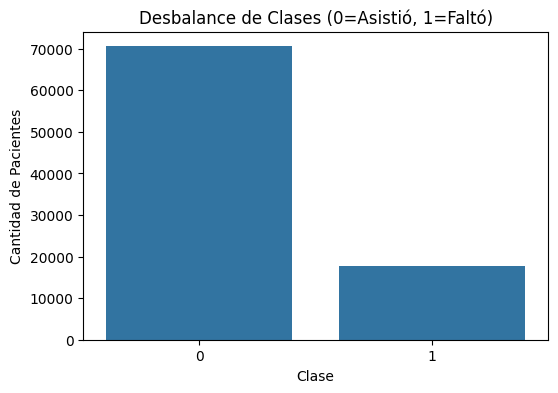

In [78]:
# Diagnóstico de Desbalance
print("--- Distribución Original (Entrenamiento) ---")
conteo = y_train.value_counts(normalize=True) * 100
print(conteo)

# Visualización
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title('Desbalance de Clases (0=Asistió, 1=Faltó)')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Pacientes')
plt.show()

Para solucionar esto usamos SMOTE para rellenar data de la clase 1 a un porcentaje del 30% para mejorar un poco la predicción. La métrica a evaluar es balanced accuracy porque es la que mejor representa el modelo a utilizar ante el contexto del dataset

In [212]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             balanced_accuracy_score, roc_curve, auc, 
                             ConfusionMatrixDisplay)
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.3, random_state=42)

X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10, 
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1 
)

model.fit(X_train_bal, y_train_bal)
print(" Modelo entrenado exitosamente.")

 Modelo entrenado exitosamente.


In [208]:
# Generamos predicciones (Clase 0 o 1) y Probabilidades (0% a 100%)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculamos métricas
bal_acc = balanced_accuracy_score(y_test, y_pred)

print("--- Reporte de Rendimiento ---")
print(f" Balanced Accuracy: {bal_acc:.2%}")
print("\nDetalle por Clase:")
print(classification_report(y_test, y_pred))

--- Reporte de Rendimiento ---
 Balanced Accuracy: 67.50%

Detalle por Clase:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69     17642
           1       0.31      0.79      0.45      4463

    accuracy                           0.61     22105
   macro avg       0.61      0.68      0.57     22105
weighted avg       0.79      0.61      0.64     22105



Análisis de Resultados
El modelo se optimizó priorizando el **Recall (Sensibilidad)** sobre la Precisión, alineándose con la estrategia operativa de la clínica:

* **Recall de la Clase 1 (79%):** De cada 100 pacientes que realmente iban a faltar, el modelo logra detectar a **79**. Esto es crítico para minimizar los "huecos" en la agenda médica que generan pérdidas económicas.
* **Trade-off:** La precisión es del 31%, lo que implica aceptar algunos "falsos positivos" (predicción de falta que al final sí asiste). Operativamente, es preferible enviar un recordatorio innecesario (bajo costo) que perder una consulta médica (alto costo).

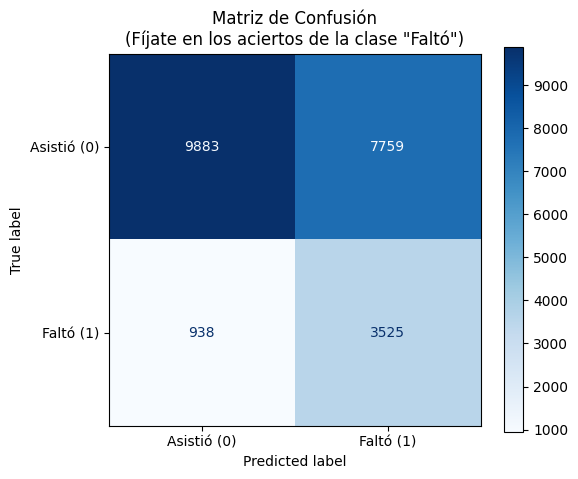

In [209]:
# Gráfico de Matriz de Confusión
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Asistió (0)', 'Faltó (1)'])

disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Matriz de Confusión\n(Fíjate en los aciertos de la clase "Faltó")')
plt.grid(False)
plt.show()

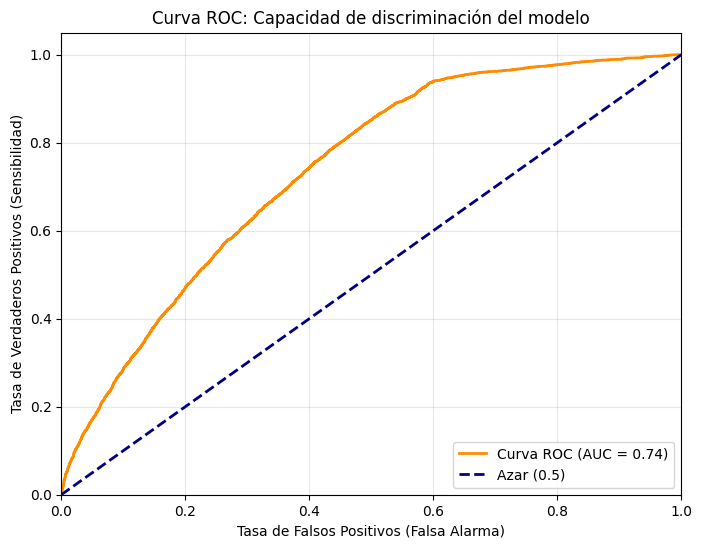

In [210]:
# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (Falsa Alarma)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC: Capacidad de discriminación del modelo')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

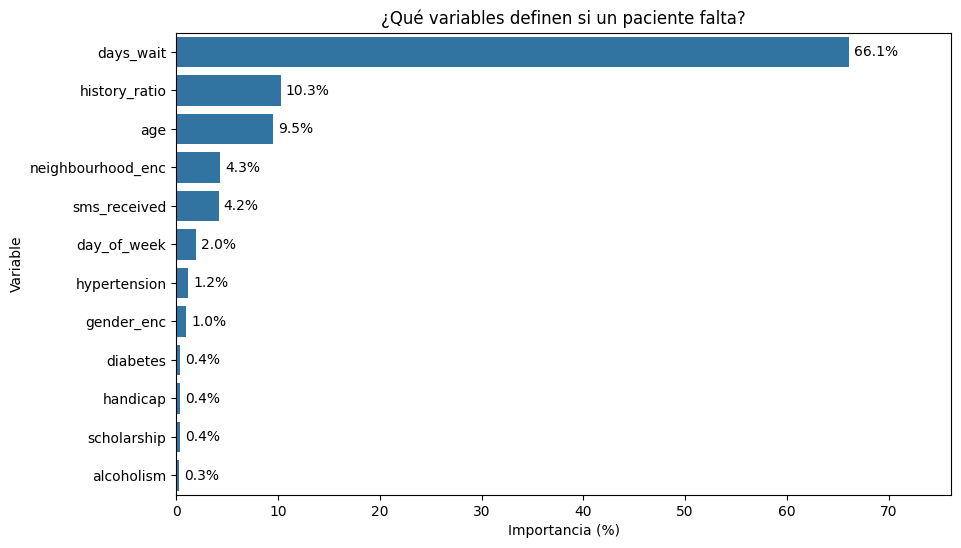

              Feature  Importance  Importance_Percent
9           days_wait    0.661253           66.125346
11      history_ratio    0.102601           10.260104
1                 age    0.094794            9.479446
2   neighbourhood_enc    0.043320            4.331966
8        sms_received    0.041604            4.160418
10        day_of_week    0.019665            1.966510
4        hypertension    0.011943            1.194324
0          gender_enc    0.009872            0.987217
5            diabetes    0.004087            0.408711
7            handicap    0.003911            0.391092
3         scholarship    0.003780            0.377950
6          alcoholism    0.003169            0.316915


In [218]:
import pandas as pd
import numpy as np

# Extraer importancia y nombres
importances = model.feature_importances_
feature_names = X.columns

# Crear DataFrame y calcular porcentaje
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Convertir a porcentaje y ordenar
feature_imp_df['Importance_Percent'] = feature_imp_df['Importance'] * 100
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance_Percent', y='Feature', data=feature_imp_df)

# Añadir etiquetas de texto con el % exacto al final de cada barra
for index, value in enumerate(feature_imp_df['Importance_Percent']):
    plt.text(value + 0.5, index, f'{value:.1f}%', va='center', fontsize=10, color='black')

plt.title('¿Qué variables definen si un paciente falta?')
plt.xlabel('Importancia (%)')
plt.ylabel('Variable')
plt.xlim(0, max(feature_imp_df['Importance_Percent']) + 10)
plt.show()

print(feature_imp_df)

--- Tasa de Ausentismo según Días de Espera ---
               mean  count
days_wait                 
0          0.046471  38562
1          0.213505   5213
2          0.238216   6725
3          0.235294   2737
4          0.232703   5290
5          0.266097   3277
6          0.247956   4037
7          0.266816   4906
8          0.287307   2332
9          0.274143   1605


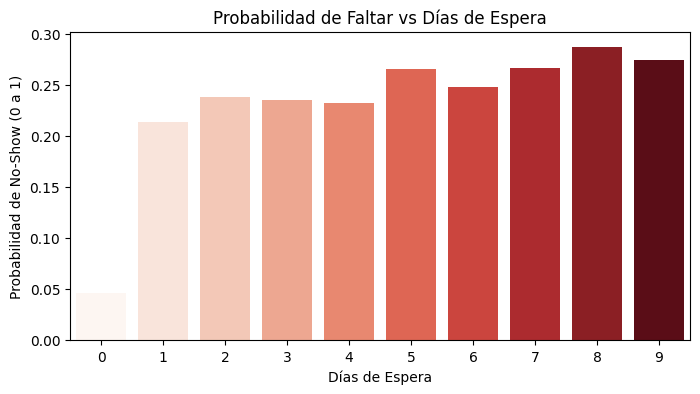

In [225]:
import pandas as pd
import matplotlib.pyplot as plt

# Usamos tu dataframe original (df) antes de transformaciones complejas
# Agrupamos por días de espera y vemos el promedio de faltas (target)
analysis = df.groupby('days_wait')['target'].agg(['mean', 'count']).head(10)

print("--- Tasa de Ausentismo según Días de Espera ---")
print(analysis)

# Visualización rápida
plt.figure(figsize=(8,4))
sns.barplot(
    x=analysis.index, 
    y=analysis['mean'], 
    hue=analysis.index,  
    palette='Reds', 
    legend=False        
)
plt.title('Probabilidad de Faltar vs Días de Espera')
plt.ylabel('Probabilidad de No-Show (0 a 1)')
plt.xlabel('Días de Espera')
plt.show()

El análisis de importancia de variables revela un hallazgo contundente:

* **Dominio del Tiempo de Espera (66%):** La variable `days_wait` es el predictor absoluto.
* **Validación:** Una auditoría de los datos confirma que las citas con **0 días de espera** (mismo día) tienen una asistencia casi perfecta (>95%), mientras que el riesgo se dispara exponencialmente a partir de las 24 horas de espera.
* **Conclusión:** No es un error del modelo (Data Leakage), sino un patrón de comportamiento humano: la **inmediatez** es el mayor driver de compromiso del paciente.

Generación de la "Capa Gold" (Output para BI)
En esta etapa final, operacionalizamos el modelo exportando los resultados para el consumo del negocio.

Generamos el archivo `dashboard.csv` que actúa como nuestra **Gold Layer**, conteniendo:
1.  Datos originales del paciente (Contexto).
2.  **Predicción de Riesgo** (1 = Alto Riesgo de No-Show).
3.  **Probabilidad** (Score de certeza del modelo).

Este archivo alimentará el Dashboard de Power BI para que el Call Center gestione proactivamente a los pacientes de alto riesgo.

In [249]:
import os
import pandas as pd

# Usamos el índice original
df_raw = pd.read_csv(os.path.join("..", "data", "citas_medicas.csv"))

# Usamos los índices de y_test para pescar exactamente los pacientes que usaste en la prueba
df_final = df.loc[y_test.index].copy()
nombres_barrios = df_raw.loc[df_final.index, 'Neighbourhood']
df_final['Barrio_Nombre'] = nombres_barrios
df_final['Prediccion_Modelo'] = y_pred  # 1 = El modelo dice que faltará
df_final['Probabilidad_Riesgo'] = y_prob # % de seguridad del modelo (ej. 0.85)
df_final['Realidad'] = y_test # Lo que pasó de verdad (para validar)

# 3. Filtramos: ¿Qué le interesa al negocio?
# Al gerente le interesa ver los "Casos de Alto Riesgo" (donde el modelo predijo 1)
call_list = df_final[df_final['Prediccion_Modelo'] == 1].sort_values(by='Probabilidad_Riesgo', ascending=False)

# 4. Guardar
output_path = os.path.join("..", "data", "dashboard.csv")
df_final.to_csv(output_path, index=False)

print(f"✅ Archivo generado: {output_path}")
print(f"📋 Se han detectado {len(call_list)} pacientes en riesgo para gestionar.")
df_final.head()

✅ Archivo generado: ..\data\dashboard.csv
📋 Se han detectado 11284 pacientes en riesgo para gestionar.


,gender_enc,age,neighbourhood_enc,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_wait,day_of_week,history_ratio,target,Barrio_Nombre,Prediccion_Modelo,Probabilidad_Riesgo,Realidad
84577,1,63,17,1,0,0,0,0,0,0,1,0.75,1,ROMÃO,0,0.389579,1
58013,0,49,38,0,0,0,0,0,0,0,2,0.00,0,NOVA PALESTINA,0,0.116061,0
107907,0,26,67,0,0,0,0,0,1,26,0,0.00,0,NAZARETH,1,0.665742,0
79291,0,17,56,1,0,0,0,0,0,0,2,0.00,0,JARDIM DA PENHA,0,0.157649,0
61833,1,74,33,0,0,0,0,0,1,14,2,0.00,0,ILHA DO BOI,0,0.445993,0


In [248]:
import duckdb
import pandas as pd

print("Ejecutando consultas SQL sobre la Capa Gold...")

# CONSULTA 1: Top 5 Barrios con más riesgo (Para mandar ambulancias o campañas)
query_barrios = """
    SELECT 
        Barrio_Nombre as Barrio,
        COUNT(*) as Total_Pacientes,
        SUM(Prediccion_Modelo) as Pacientes_Riesgo,
        ROUND(AVG(Probabilidad_Riesgo) * 100, 1) as Probabilidad_Promedio
    FROM df_final
    GROUP BY Barrio_Nombre
    HAVING COUNT(*) > 50
    ORDER BY Pacientes_Riesgo DESC
    LIMIT 5
"""

# CONSULTA 2: Análisis por Grupo de Edad (Segmentación de Clientes)
query_edades = """
    SELECT 
        CASE 
            WHEN age < 18 THEN '0-17 Niños'
            WHEN age BETWEEN 18 AND 30 THEN '18-30 Jóvenes'
            WHEN age BETWEEN 31 AND 60 THEN '31-60 Adultos'
            ELSE '60+ Seniors'
        END as Grupo_Etario,
        COUNT(*) as Total,
        SUM(Prediccion_Modelo) as Prediccion_Faltas,
        ROUND((SUM(Prediccion_Modelo) * 100.0 / COUNT(*)), 1) as Tasa_Riesgo_Pct
    FROM df_final
    GROUP BY 1
    ORDER BY Tasa_Riesgo_Pct DESC
"""

# Ejecutamos las queries
print("\n--- Top 5 Barrios Críticos (SQL Report) ---")
print(duckdb.sql(query_barrios).df())

print("\n--- Riesgo por Segmento de Edad (SQL Report) ---")
print(duckdb.sql(query_edades).df())

Ejecutando consultas SQL sobre la Capa Gold...

--- Top 5 Barrios Críticos (SQL Report) ---
            Barrio  Total_Pacientes  Pacientes_Riesgo  Probabilidad_Promedio
0   JARDIM CAMBURI             1521             793.0                   43.2
1      MARIA ORTIZ             1188             593.0                   42.5
2      RESISTÊNCIA              867             433.0                   42.2
3  JARDIM DA PENHA              778             395.0                   43.4
4           CENTRO              690             358.0                   43.7

--- Riesgo por Segmento de Edad (SQL Report) ---
    Grupo_Etario  Total  Prediccion_Faltas  Tasa_Riesgo_Pct
0  18-30 Jóvenes   3682             2418.0             65.7
1     0-17 Niños   5349             3275.0             61.2
2  31-60 Adultos   9045             4779.0             52.8
3    60+ Seniors   4029              812.0             20.2
